In [1]:
base_dir = "/Users/bin/Desktop/CV_Assignment/Dataset_filtered"

In [2]:
import random
import numpy as np
import pandas as pd
import re
import json
from pathlib import Path

import os
import shutil

import matplotlib.pyplot as plt
import torch


import torchvision

from torch import nn
from torchvision import transforms, datasets
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary

from PIL import Image

# split train and test

In [3]:
import os
import glob
import random
import re
import shutil

# Set seed for reproducibility
# random.seed(42)

def trainval_split(base_dir):

    # Define base directories
    trainval_dir = os.path.join(base_dir, "TrainVal")
    color_dir = os.path.join(trainval_dir, "color")
    label_dir = os.path.join(trainval_dir, "label")

    # Define destination directories for train and validation splits
    train_color_dir = os.path.join(base_dir, "train", "color")
    train_label_dir = os.path.join(base_dir, "train", "label")
    val_color_dir = os.path.join(base_dir, "val", "color")
    val_label_dir = os.path.join(base_dir, "val", "label")

    # Create the destination directories if they don't exist
    for d in [train_color_dir, train_label_dir, val_color_dir, val_label_dir]:
        os.makedirs(d, exist_ok=True)

    # Find all jpg files in the color folder
    image_files = glob.glob(os.path.join(color_dir, "*.jpg"))

    # Group files by animal name (assumes format like "Abyssinian_1.jpg")
    groups = {}
    pattern = re.compile(r'(.+)_\d+\.jpg')  # capture group for the animal name
    for image_file in image_files:
        basename = os.path.basename(image_file)
        match = pattern.match(basename)
        if match:
            animal = match.group(1)
        else:
            animal = "unknown"
        groups.setdefault(animal, []).append(basename)

    # Split the files for each animal into train (80%) and val (20%)
    train_list = []
    val_list = []
    for animal, files in groups.items():
        random.shuffle(files)
        split_index = int(0.8 * len(files))
        train_files = files[:split_index]
        val_files = files[split_index:]
        train_list.extend(train_files)
        val_list.extend(val_files)

    # Define output text file paths
    train_txt_path = os.path.join(base_dir, "train.txt")
    val_txt_path = os.path.join(base_dir, "val.txt")

    # Copy files to new folders and write paths to train.txt and val.txt
    with open(train_txt_path, "w") as train_file, open(val_txt_path, "w") as val_file:
        # Process train split
        for filename in train_list:
            # Copy color image
            src_color = os.path.join(color_dir, filename)
            dst_color = os.path.join(train_color_dir, filename)
            shutil.copy2(src_color, dst_color)

            # Derive corresponding label filename (change extension from .jpg to .png)
            label_filename = filename.replace(".jpg", ".png")
            src_label = os.path.join(label_dir, label_filename)
            dst_label = os.path.join(train_label_dir, label_filename)
            if os.path.exists(src_label):
                shutil.copy2(src_label, dst_label)

            # Write relative paths to train.txt (format: "train/color/<filename> train/label/<label_filename>")
            train_file.write(f"{os.path.join('train','color',filename)} {os.path.join('train','label',label_filename)}\n")

        # Process validation split
        for filename in val_list:
            # Copy color image
            src_color = os.path.join(color_dir, filename)
            dst_color = os.path.join(val_color_dir, filename)
            shutil.copy2(src_color, dst_color)

            # Corresponding label filename
            label_filename = filename.replace(".jpg", ".png")
            src_label = os.path.join(label_dir, label_filename)
            dst_label = os.path.join(val_label_dir, label_filename)
            if os.path.exists(src_label):
                shutil.copy2(src_label, dst_label)

            # Write relative paths to val.txt
            val_file.write(f"{os.path.join('val','color',filename)} {os.path.join('val','label',label_filename)}\n")

    print("Data splitting and copying complete.")
    print(f"Train list written to {train_txt_path}")
    print(f"Val list written to {val_txt_path}")

# trainval_split(base_dir)


# Resize images

initialize一个dictionary，对每个image resize之前，记录它对应的mask的height和width并写入字典，最后将字典写入一个叫original_sizes.json的file里

In [4]:
import os
import cv2
import shutil
import json

# Set target dimensions (adjust as needed)
TARGET_WIDTH = 256
TARGET_HEIGHT = 256
target_size = (TARGET_WIDTH, TARGET_HEIGHT)

# Directories for train and val splits
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")

# Create destination directories:
# For training, we resize images but copy masks unchanged.
resized_train_color_dir = os.path.join(base_dir, "train_resized", "color")
resized_train_label_dir = os.path.join(base_dir, "train_resized", "label")

# For validation, we resize images and copy masks unchanged.
resized_val_color_dir = os.path.join(base_dir, "val_resized", "color")
resized_val_label_dir = os.path.join(base_dir, "val_resized", "label")

for d in [resized_train_color_dir, resized_train_label_dir,
          resized_val_color_dir, resized_val_label_dir]:
    os.makedirs(d, exist_ok=True)

# Dictionary to store original image sizes before resizing
original_sizes = {}

def resize_and_save(src_path, dst_path, target_size):
    """
    Resize an image and save it (don't record size here anymore).
    """
    img = cv2.imread(src_path, cv2.IMREAD_COLOR)
    if img is None:
        print("Error reading:", src_path)
        return
    resized = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)
    cv2.imwrite(dst_path, resized)

def process_data(color_source, label_source, resized_color_dest, resized_label_dest, original_sizes_dict):
    """
    Processes a dataset split:
    - Resizes color images and saves them.
    - Copies label masks unchanged, and stores their original sizes with clean keys.
    """
    # Resize color images
    for filename in sorted(os.listdir(color_source)):
        if filename.lower().endswith(".jpg"):
            src_path = os.path.join(color_source, filename)
            dst_path = os.path.join(resized_color_dest, filename)
            resize_and_save(src_path, dst_path, target_size)

    # Copy masks and record original sizes
    for filename in sorted(os.listdir(label_source)):
        if filename.lower().endswith(".png"):
            src_path = os.path.join(label_source, filename)
            dst_path = os.path.join(resized_label_dest, filename)

            # Load mask
            mask = cv2.imread(src_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                print("Error reading mask:", src_path)
                continue

            # 🔥 Clean filename key: remove suffix like ".png"
            img_key = os.path.splitext(filename)[0]  # "Abyssinian_1.png" → "Abyssinian_1"
            original_sizes_dict[img_key] = list(mask.shape)  # Ensure JSON serializable: [H, W]

            # Copy mask as-is
            shutil.copy2(src_path, dst_path)

# -----------------------------------------
# Process Training Data
# -----------------------------------------
train_color_source = os.path.join(train_dir, "color")
train_label_source = os.path.join(train_dir, "label")

# process_data(train_color_source, train_label_source, resized_train_color_dir, resized_train_label_dir, original_sizes)

# # -----------------------------------------
# # Process Validation Data
# # -----------------------------------------
val_color_source = os.path.join(val_dir, "color")
val_label_source = os.path.join(val_dir, "label")

# process_data(val_color_source, val_label_source, resized_val_color_dir, resized_val_label_dir, original_sizes)

# Save original sizes to a JSON file
original_size_json_path = os.path.join(base_dir, "original_sizes.json")
with open(original_size_json_path, "w") as f:
    json.dump(original_sizes, f, indent=4)

# print(f"✅ Processing complete. Original sizes saved to {original_size_json_path}.")

# randaugment (Do the augmentations)


In [5]:
import os
import random
from PIL import Image, ImageOps, ImageEnhance
import math
from torchvision.transforms import functional as F
from torchvision.transforms.functional import InterpolationMode

# Define the RandAugment operation pool (14 ops as in the original paper)
RA_OPERATIONS = [
    "Identity", "AutoContrast", "Equalize",
    "Rotate", "Solarize", "Color", "Posterize",
    "Contrast", "Brightness", "Sharpness",
    "ShearX", "ShearY", "TranslateX", "TranslateY"
]

def apply_operation(img, mask, op_name, magnitude):
    """
    Apply a single augmentation operation to the image (and mask, if applicable).
    'magnitude' is on a 0-10 scale indicating severity.
    """
    if op_name == "Identity":
        return img, mask  # no change

    if op_name == "AutoContrast":
        img = ImageOps.autocontrast(img)
        return img, mask

    if op_name == "Equalize":
        img = ImageOps.equalize(img)
        return img, mask

    if op_name == "Rotate":
        max_deg = 30.0
        angle = magnitude / 10.0 * max_deg
        if random.random() < 0.5:
            angle = -angle
        img = img.rotate(angle, resample=Image.BILINEAR, fillcolor=0)
        mask = mask.rotate(angle, resample=Image.NEAREST, fillcolor=0)
        return img, mask

    if op_name == "Solarize":
        thresh = int(256 - (magnitude / 10.0) * 256)
        img = ImageOps.solarize(img, thresh)
        return img, mask

    if op_name == "Color":
        factor = 1.0 + (magnitude / 10.0) * 0.9
        if random.random() < 0.5:
            factor = 1.0 - (magnitude / 10.0) * 0.9
        img = ImageEnhance.Color(img).enhance(factor)
        return img, mask

    if op_name == "Posterize":
        bits = int(round(8 - (magnitude / 10.0) * 4))
        bits = max(1, bits)
        img = ImageOps.posterize(img, bits)
        return img, mask

    if op_name == "Contrast":
        factor = 1.0 + (magnitude / 10.0) * 0.9
        if random.random() < 0.5:
            factor = 1.0 - (magnitude / 10.0) * 0.9
        img = ImageEnhance.Contrast(img).enhance(factor)
        return img, mask

    if op_name == "Brightness":
        factor = 1.0 + (magnitude / 10.0) * 0.9
        if random.random() < 0.5:
            factor = 1.0 - (magnitude / 10.0) * 0.9
        img = ImageEnhance.Brightness(img).enhance(factor)
        return img, mask

    if op_name == "Sharpness":
        factor = 1.0 + (magnitude / 10.0) * 0.9
        if random.random() < 0.5:
            factor = 1.0 - (magnitude / 10.0) * 0.9
        img = ImageEnhance.Sharpness(img).enhance(factor)
        return img, mask

    # Geometric operations: these need to be applied identically to the mask
    if op_name == "ShearX":
        shear_factor = magnitude / 10.0 * 0.3
        if random.random() < 0.5:
            shear_factor = -shear_factor
        shear_degrees = math.degrees(math.atan(shear_factor))
        img = F.affine(img, angle=0.0, translate=(0, 0), scale=1.0,
                       shear=(shear_degrees, 0.0),
                       interpolation=InterpolationMode.BILINEAR, fill=0)
        mask = F.affine(mask, angle=0.0, translate=(0, 0), scale=1.0,
                        shear=(shear_degrees, 0.0),
                        interpolation=InterpolationMode.NEAREST, fill=0)
        return img, mask

    if op_name == "ShearY":
        shear_factor = magnitude / 10.0 * 0.3
        if random.random() < 0.5:
            shear_factor = -shear_factor
        shear_degrees = math.degrees(math.atan(shear_factor))
        img = F.affine(img, angle=0.0, translate=(0, 0), scale=1.0,
                       shear=(0.0, shear_degrees),
                       interpolation=InterpolationMode.BILINEAR, fill=0)
        mask = F.affine(mask, angle=0.0, translate=(0, 0), scale=1.0,
                        shear=(0.0, shear_degrees),
                        interpolation=InterpolationMode.NEAREST, fill=0)
        return img, mask

    if op_name == "TranslateX":
        max_frac = 0.45
        dx = int(round(magnitude / 10.0 * max_frac * img.width))
        if random.random() < 0.5:
            dx = -dx
        img = F.affine(img, angle=0.0, translate=(dx, 0), scale=1.0,
                       shear=(0.0, 0.0), interpolation=InterpolationMode.BILINEAR, fill=0)
        mask = F.affine(mask, angle=0.0, translate=(dx, 0), scale=1.0,
                        shear=(0.0, 0.0), interpolation=InterpolationMode.NEAREST, fill=0)
        return img, mask

    if op_name == "TranslateY":
        max_frac = 0.45
        dy = int(round(magnitude / 10.0 * max_frac * img.height))
        if random.random() < 0.5:
            dy = -dy
        img = F.affine(img, angle=0.0, translate=(0, dy), scale=1.0,
                       shear=(0.0, 0.0), interpolation=InterpolationMode.BILINEAR, fill=0)
        mask = F.affine(mask, angle=0.0, translate=(0, dy), scale=1.0,
                        shear=(0.0, 0.0), interpolation=InterpolationMode.NEAREST, fill=0)
        return img, mask

    return img, mask

def randaugment_image_mask(img, mask, N, M):
    """Apply RandAugment (N operations with magnitude M) to the given PIL image and mask."""
    ops = random.sample(RA_OPERATIONS, N)  # choose N distinct ops at random
    for op in ops:
        img, mask = apply_operation(img, mask, op, M)
    return img, mask

def run_randaugment_train_resized(input_base, output_base, N=2, M=9, num_aug=3):
    """
    Process each image-mask pair from the resized training data.

    Expects:
      - Images in:  input_base/train_resized/color
      - Masks in:   input_base/train_resized/label

    Saves augmented outputs in:
      - output_base/train_randaugmented/color
      - output_base/train_randaugmented/label

    Additionally, copies the original image and mask.
    Generates 'num_aug' augmented images per original image.
    """
    in_img_dir = os.path.join(input_base, "train_resized", "color")
    in_mask_dir = os.path.join(input_base, "train_resized", "label")
    out_img_dir = os.path.join(output_base, "train_randaugmented", "color")
    out_mask_dir = os.path.join(output_base, "train_randaugmented", "label")
    os.makedirs(out_img_dir, exist_ok=True)
    os.makedirs(out_mask_dir, exist_ok=True)

    for filename in os.listdir(in_img_dir):
        if not filename.lower().endswith(".jpg"):
            continue
        img_path = os.path.join(in_img_dir, filename)
        base_name, ext = os.path.splitext(filename)
        # Try common mask extensions (often masks are stored as .png)
        mask_candidates = [base_name + ".png", base_name + ".jpg", base_name + ".jpeg", base_name + ".bmp", base_name + ".tif"]
        mask_path = None
        for cand in mask_candidates:
            cand_path = os.path.join(in_mask_dir, cand)
            if os.path.exists(cand_path):
                mask_path = cand_path
                break
        if mask_path is None:
            print(f"Mask for image {filename} not found, skipping.")
            continue

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        if mask.mode not in ["L", "I"]:
            mask = mask.convert("L")

        # Save the original image and mask in the output folders
        orig_img_path = os.path.join(out_img_dir, f"{base_name}_orig.jpg")
        orig_mask_path = os.path.join(out_mask_dir, f"{base_name}_orig.png")
        img.save(orig_img_path)
        mask.save(orig_mask_path)
        print(f"Saved original image to {orig_img_path} and mask to {orig_mask_path}")

        # Generate and save augmented versions
        for i in range(num_aug):
            aug_img, aug_mask = randaugment_image_mask(img, mask, N, M)
            out_img_path = os.path.join(out_img_dir, f"{base_name}_aug_{i}.jpg")
            out_mask_path = os.path.join(out_mask_dir, f"{base_name}_aug_{i}.png")
            aug_img.save(out_img_path)
            aug_mask.save(out_mask_path)
            print(f"Saved augmented image to {out_img_path} and mask to {out_mask_path}")

# --- Example usage in a notebook cell ---
# Set your base directory. In your case, it is:
# We'll use the same base directory for output (augmented data will be saved under a new subfolder)
# run_randaugment_train_resized(base_dir, base_dir, N=2, M=9, num_aug=3)


将images和masks都写入DataLoader里，但同时也要记录每张image的name以便后面查询mask的original size
除此以外，对于mask tensor化的操作还要更改。我们目前有4个class:[cat, dog, background, boundary] 分别对应class 0,1,2,3,我们通过默认的transforms.ToTensor()使得mask的每个tensor的每个像素都变为该像素的值后，我们还要进一步操作:对于每个tensor值，如果是0，就把该值变为2（意为background),如果是1，就把这个值变为3（意为boundary),如果是介于0-1之间的值，我们看这个mask的filename，如果filename的第一个字母是大写，将该值变为0(意为猫),反之如果是小写，就变成1（意为狗)

Unique class indices and pixel counts:
Class 1: 17542 pixels
Class 2: 36833 pixels
Class 3: 5925 pixels


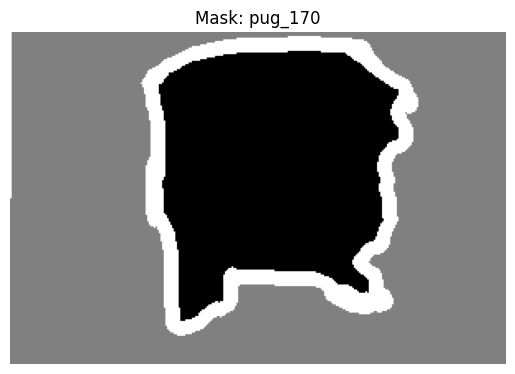

In [13]:
# from drive.MyDrive.CV_Assignment.custom_dataset import CustomDataset
from custom_dataset import CustomDataset
# Create dataset
dataset = CustomDataset(
    image_dir = os.path.join(base_dir, "train_randaugmented", "color"),
    mask_dir = os.path.join(base_dir, "train_randaugmented", "label"),
    transform=transforms.ToTensor()
)

# Custom collate function to handle filenames
def custom_collate_fn(batch):
    images, masks, img_names, mask_names = zip(*batch)

    img_names = [re.sub(r'(_aug_\d+|_orig)$', '', name) for name in img_names]
    mask_names = [re.sub(r'(_aug_\d+|_orig)$', '', name) for name in mask_names]

    images = torch.stack(images)
    # masks = torch.stack(masks)
    return images, list(masks), list(img_names), list(mask_names)

# Create DataLoader with shuffle=True but keeping filenames
train_dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)

# Test DataLoader
# for images, masks, img_names, mask_names in train_dataloader:
#     print("Batch Image Filenames:", img_names)
#     print("Batch Mask Filenames:", mask_names)
#     break

# 取第一个 batch
# first_batch = next(iter(train_dataloader))

# # 解包 batch 内容
# images, masks, img_names, mask_names = first_batch

# # 取第一个掩膜
# first_mask = masks[0]  # LongTensor, shape: (H, W)

# # 查看唯一类别标签及其像素数量
# unique_classes, counts = torch.unique(first_mask, return_counts=True)
# print("Unique class indices and pixel counts:")
# for cls, count in zip(unique_classes.tolist(), counts.tolist()):
#     print(f"Class {cls}: {count} pixels")

# # 可视化掩膜
# import matplotlib.pyplot as plt

# plt.imshow(first_mask, cmap="gray")
# plt.title(f"Mask: {mask_names[0]}")
# plt.axis("off")
# plt.show()

In [ ]:
import os
import random
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# Step 1: Define path and list mask files
mask_dir = os.path.join(base_dir, "val_resized", "label")
mask_files = [f for f in os.listdir(mask_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Step 2: Pick a random file
random_mask_file = random.choice(mask_files)
mask_path = os.path.join(mask_dir, random_mask_file)

# Step 3: Open the image (no conversion)
mask = Image.open(mask_path)

# Step 4: Convert to tensor
mask_tensor = transforms.ToTensor()(mask)  # Shape: (C, H, W)

print(f"Loaded mask: {random_mask_file}")
print(f"Tensor shape: {mask_tensor.shape}")

# Step 5: Find unique pixel values
if mask_tensor.ndim == 3 and mask_tensor.shape[0] == 3:  # RGB
    pixels = mask_tensor.view(3, -1).permute(1, 0)  # shape: (H*W, 3)
    pixels = torch.round(pixels * 255).to(torch.uint8)
    unique_colors, counts = torch.unique(pixels, return_counts=True, dim=0)

    print("Unique RGB pixel values and their counts:")
    for color, count in zip(unique_colors, counts):
        print(f"{color.tolist()} --> {count.item()} pixels")

else:  # Grayscale or single-channel
    mask_flat = mask_tensor.view(-1)
    unique_values, counts = torch.unique(mask_flat, return_counts=True)

    print("Unique grayscale pixel values and their counts:")
    for val, count in zip(unique_values, counts):
        print(f"{val.item():.6f} --> {count.item()} pixels")

# Step 6: Display the mask image
plt.imshow(mask, cmap='gray')
plt.title(f"Random Mask: {random_mask_file}")
plt.axis("off")
plt.show()

In [ ]:
# from drive.MyDrive.CV_Assignment.unet import UNet
# import torch.optim as optim

# model = UNet(in_channels=3, out_channels=4)

# # Move model to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)


# x = torch.randn(32, 3, 256, 256)  # Example input tensor
# output = model(x)
# print(output.shape)

# Training

In [ ]:
import torch.nn.functional as F
def resize_multiclass_logits(logits, img_names, original_sizes_dict):
    resized_logits = []
    for i in range(len(logits)):
        name = img_names[i]
        orig_h, orig_w = original_sizes_dict[name]
        resized = F.interpolate(
            logits[i].unsqueeze(0),  # shape (1, 4, 256, 256)
            size=(orig_h, orig_w),
            mode="bilinear",
            align_corners=False
        )
        resized_logits.append(resized.squeeze(0))  # shape: (4, H, W)
    return resized_logits  # list of tensors




with open(os.path.join(base_dir, "original_sizes.json"), "r") as f:
    original_sizes_dict = json.load(f)



# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define number of epochs
NUM_EPOCHS = 100
PRINT_INTERVAL = 10





# Move model to device
model = model.to(device)

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop over multiple epochs
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0.0

    for images, masks, img_names, mask_names in train_dataloader:
        images = images.to(device)
        masks = [m.to(device) for m in masks]
        optimizer.zero_grad()

        # 1️⃣ Forward pass — output shape: (B, 4, 256, 256)
        logits = model(images)

        # 2️⃣ Resize each predicted logits map to original mask size
        resized_logits = resize_multiclass_logits(logits, img_names, original_sizes_dict)  # List of (4, H, W)

        # 3️⃣ Compute per-sample loss (cross entropy expects (C, H, W) + (H, W))
        total_loss = 0
        for pred_logits, gt_mask in zip(resized_logits, masks):
          # Add batch dimension to both tensors
          pred_logits = pred_logits.unsqueeze(0)  # shape: (1, 4, H, W)
          gt_mask = gt_mask.unsqueeze(0)          # shape: (1, H, W)

          loss = loss_fn(pred_logits, gt_mask)
          total_loss += loss

        # 5️⃣ Backward + update
        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()

    avg_epoch_loss = epoch_loss / len(train_dataloader)

    if (epoch + 1) % PRINT_INTERVAL == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Loss: {avg_epoch_loss:.4f}")

print("🎉 Training complete!")

# Display the predicted mask of a random image from val_resized

In [ ]:
# --- Define your model architecture ---
# Dummy example: Replace with your actual UNet model class
import torch.nn.functional as F
import matplotlib.pyplot as plt

# === 2. Load model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, out_channels=4).to(device)
model.load_state_dict(torch.load("/Users/bin/Desktop/CV_Assignment/Model/unet_100_epochs.pth", map_location=device))
model.eval()

# === 3. Load original size dictionary ===
with open("/Users/bin/Desktop/CV_Assignment/Dataset_filtered/original_sizes.json", "r") as f:
    original_sizes = json.load(f)

# === 4. Load and transform image ===
val_dir = "/Users/bin/Desktop/CV_Assignment/Dataset_filtered/val_resized/color"
img_names = sorted(os.listdir(val_dir))
img_name = random.choice(img_names)
img_path = os.path.join(val_dir, img_name)
img_key = os.path.splitext(img_name)[0]

print(f"Predicting on image: {img_name}")

# Resize transform (same as training)
transform = transforms.Compose([
    transforms.ToTensor()
])

image = Image.open(img_path).convert("RGB")
image_tensor = transform(image).unsqueeze(0).to(device)  # shape: (1, 3, 256, 256)

# === 5. Predict logits ===
with torch.no_grad():
    logits = model(image_tensor)  # shape: (1, 4, 256, 256)
    pred_class = torch.argmax(logits, dim=1, keepdim=True)  # shape: (1, 1, 256, 256)

    # === 6. Resize predicted mask back to original size ===
    orig_h, orig_w = original_sizes[img_key]
    pred_resized = torch.nn.functional.interpolate(pred_class.float(), size=(orig_h, orig_w), mode="nearest")  # shape: (1, 1, H, W)
    print("Unique predicted class values:", torch.unique(pred_resized))
    final_mask = pred_resized.squeeze().cpu().long()  # shape: (H, W), values in [0,3] — corresponds to class index

# === 7. Display or print the predicted mask values ===
print(f"Predicted mask shape: {final_mask.shape}")
print(f"Unique predicted classes: {torch.unique(final_mask)}")


# Convert image tensor back to numpy for display (un-normalized)
image_np = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()

# Predicted mask: shape (H, W), values in [0, 3]
mask_np = final_mask.cpu().numpy()

# Optional: create a colormap for the 4 classes
# Let's define: 0=cat, 1=dog, 2=background, 3=boundary
cmap = np.array([
    [255, 0, 0],     # red for cat
    [0, 255, 0],     # green for dog
    [0, 0, 0],       # black for background
    [0, 0, 255],     # blue for boundary
], dtype=np.uint8)

# Map each class to color
mask_rgb = cmap[mask_np]  # shape: (H, W, 3)

# Display
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title("Input Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask_rgb)
plt.title("Predicted Mask")
plt.axis("off")

plt.tight_layout()
plt.show()

#First compute accuracy (IoU/Dice) on val_resized

treat boundary as a new class: boundary for now. currently we have 4 classes: [cat, dog, boundary, background],

In [ ]:
def compute_iou(pred, target, num_classes):
    """Compute per-class IoU"""
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)
    return ious

def compute_dice(pred, target, num_classes):
    """Compute per-class Dice coefficient"""
    dices = []
    pred = pred.view(-1)
    target = target.view(-1)
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        total = pred_inds.sum().item() + target_inds.sum().item()
        if total == 0:
            dices.append(float('nan'))
        else:
            dices.append(2 * intersection / total)
    return dices

In [ ]:
!pip3 install torchmetrics --upgrade

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torchmetrics import JaccardIndex  # IoU
import os, json
from tqdm import tqdm
from unet import UNet
from custom_dataset import CustomDataset

# === Configuration ===
NUM_CLASSES = 4
CLASS_NAMES = ["Cat", "Dog", "Background", "Boundary"]

base_dir = "/Users/bin/Desktop/CV_Assignment/Dataset_filtered"
MODEL_PATH = "/Users/bin/Desktop/CV_Assignment/Model/unet_80_epochs.pth"
original_sizes_path = os.path.join(base_dir, "original_sizes.json")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load model ===
model = UNet(in_channels=3, out_channels=NUM_CLASSES).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# === Load original sizes ===
with open(original_sizes_path) as f:
    original_sizes = json.load(f)

# === Load validation dataset ===
val_dataset = CustomDataset(
    image_dir=os.path.join(base_dir, "val_resized", "color"),
    mask_dir=os.path.join(base_dir, "val_resized", "label"),
    transform=transforms.ToTensor()
)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# === Define IoU metric ===
iou_metric = JaccardIndex(task="multiclass", num_classes=NUM_CLASSES, average="none").to(device)

# === Evaluation loop ===
with torch.no_grad():
    for image, mask, img_name, _ in tqdm(val_loader):
        image = image.to(device)
        mask = mask.squeeze(0).to(device).long()

        # Predict logits
        logits = model(image)  # (1, 4, 256, 256)
        pred_class = torch.argmax(logits, dim=1).float()  # (1, 256, 256)

        # Resize prediction and GT back to original size
        orig_h, orig_w = original_sizes[img_name[0]]
        pred_resized = F.interpolate(pred_class.unsqueeze(1), size=(orig_h, orig_w), mode="nearest").squeeze(1).long()
        gt_resized = F.interpolate(mask.unsqueeze(0).unsqueeze(0).float(), size=(orig_h, orig_w), mode="nearest").squeeze(0).long()

        # Update IoU metric (handles variable size)
        iou_metric.update(pred_resized.to(device), gt_resized.to(device))

# === Compute results ===
iou_per_class = iou_metric.compute()  # shape: (num_classes,)

print("\n📊 Per-Class IoU:")
for i, iou in enumerate(iou_per_class):
    print(f"Class {i} ({CLASS_NAMES[i]}): IoU = {iou:.4f}")

mean_iou = iou_per_class[:3].mean()  # exclude boundary if needed
print(f"\n➡️ Mean IoU (first 3 classes): {mean_iou:.4f}")